In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

In [2]:
data_marix = np.load('extract/extact_matrix.npy', allow_pickle=True)

In [3]:

from scipy.signal import convolve2d

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


In [4]:
#data_marix_gray=np.mean(data_marix,axis=3)
data_marix_gray = np.load('extract/extact_matrix_uni.npy', allow_pickle=True)

Gaussien filter

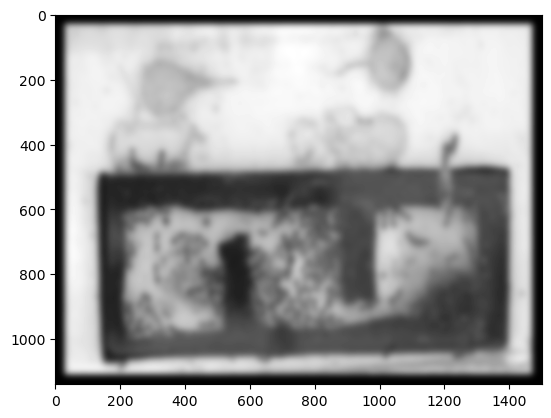

In [5]:
smooth_fourmis = convolve2d(data_marix_gray[0], gaussianKernel(10))
plt.imshow(smooth_fourmis, cmap='gray')

thresholding

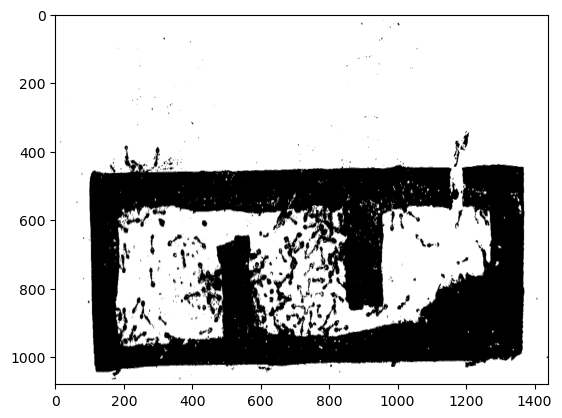

In [46]:
test=np.where(data_marix_gray[0]>90,255,0)
plt.imshow(test, cmap='gray')

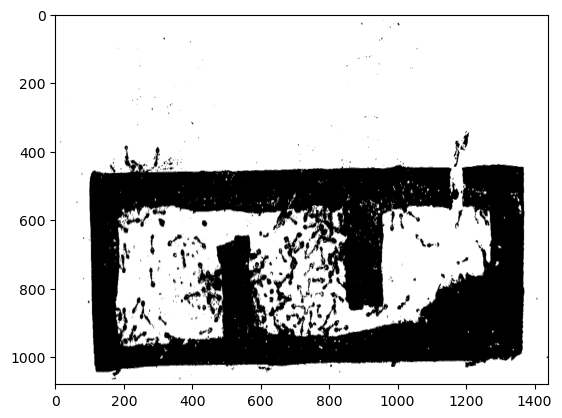

In [47]:
test1=np.where(data_marix_gray[1]>90,255,0)
plt.imshow(test, cmap='gray')

substraction

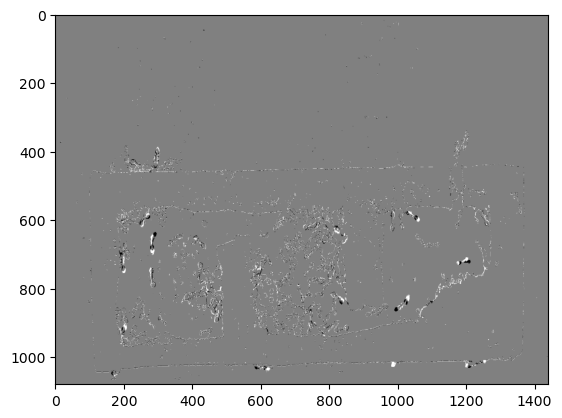

In [52]:
pos=np.where(test1-test>0,0,255)
neg=np.where(test1-test<0,0,255)
plt.imshow(test1-test, cmap='gray')

In [58]:
sub=test1-test

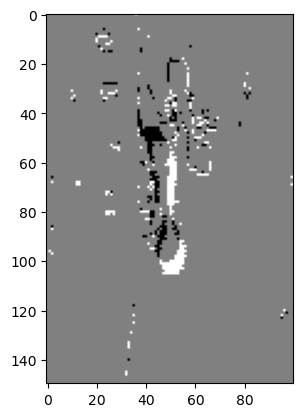

In [60]:
plt.imshow(sub[650:800,150:250],cmap='gray')

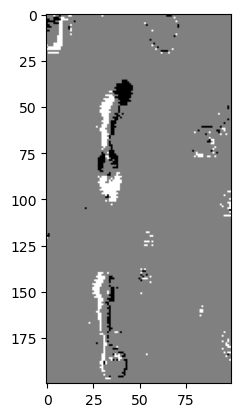

In [62]:
plt.imshow(sub[600:800,250:300],cmap='gray')

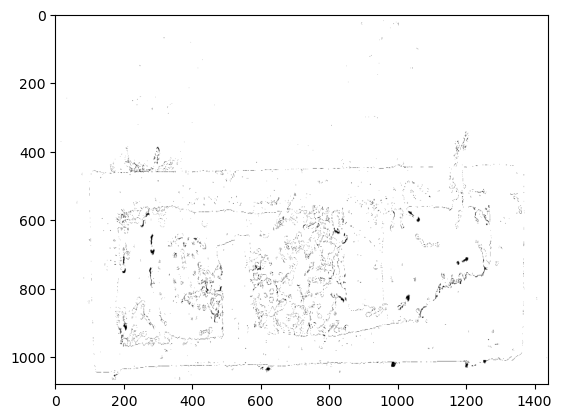

In [51]:
plt.imshow(pos, cmap='gray')